In [ ]:
pip install kagglehub

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import pandas as pd
import re
from collections import Counter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
from tqdm import tqdm
import torch.optim as optim
from sklearn.decomposition import PCA

In [65]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Number of CUDA devices: 1


# Dataset

In [66]:
path = kagglehub.dataset_download("bwandowando/reddit-rbrazil-subreddit-dataset")

In [67]:
comments_dataset = pd.read_csv(path+"/brasil_subreddit_comments.csv")

In [68]:
def preprocess_text(text):
  if not isinstance(text, str):
        return ""

  text = text.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^\w\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()

  return text

In [69]:
def build_vocab(tokenized_texts, max_vocab_size, min_count):
  word_counts = Counter()
  for text in tokenized_texts:
      word_counts.update(text)

  # print(f"Total unique words: {len(word_counts)}")
  # print(f"Most common words: {word_counts.most_common(10)}")

  filtered_words = [word for word, count in word_counts.most_common(max_vocab_size)
                     if count >= min_count]

  # Add special tokens (padding, unknown)
  vocab = ['<pad>', '<unk>'] + filtered_words

  word_to_idx = { word: idx for idx, word in enumerate(vocab)}
  idx_to_word = { idx: word for word, idx in word_to_idx.items()}

  return word_to_idx, idx_to_word, len(vocab)


In [70]:
def encode(text, word_to_idx):
  if isinstance(text, str):
    tokens = text.lower().split()
  else:
    tokens = text

  indices = [word_to_idx.get(token, word_to_idx['<unk>']) for token in tokens]

  return indices

def decode(indices, idx_to_word):
  words = [idx_to_word[i] for i in indices]
  text = ' '.join(words)

  return text

In [71]:
def create_context_target_pairs(tokenized_comments, context_size):
  pairs = []

  for text in tokenized_comments:
    if len(text) <= context_size:
      continue

    for i in range(len(text) - context_size):
      context = text[i:i+context_size]
      target = text[i+context_size]
      pairs.append((context, target))

    return pairs

In [72]:
def prepare_sequence_tensors(pairs, word_to_idx):
  context_tensors = []
  target_tensors = []

  for context, target in pairs:
    context_indices = encode(context, word_to_idx)
    target_index = word_to_idx.get(target, word_to_idx['<unk>'])

    context_tensor = torch.tensor(context_indices)
    target_tensor = torch.tensor(target_index)

    context_tensors.append(context_tensor)
    target_tensors.append(target_tensor)

  return context_tensors, target_tensors

In [74]:
print("Preprocessing comments...")
processed_comments = []
for comment in comments_dataset['body']:
    processed = preprocess_text(comment)
    if processed and len(processed.split()) >= 6:  # keep comments with at least X words
        processed_comments.append(processed)

print("Tokenizing comments...")
tokenized_comments = [comment.split() for comment in processed_comments]

print("Building vocab...")
(word_to_idx, idx_to_word, vocab_size) = build_vocab(tokenized_comments, 20000, 5)

print(f"Vocab size: {vocab_size}")

Preprocessing comments...
Tokenizing comments...
Building vocab...
Vocab size: 20002


# Example Embeddings

In [20]:
vocab = { "the":0, "cat":1, "sat":2, "on":3, "mat":4 }
embeddings_dim = 3

C = torch.randn((len(vocab), embeddings_dim), requires_grad=True)
C

tensor([[ 0.2135,  0.5482,  0.0233],
        [-0.1448, -1.3261,  0.3651],
        [-1.0038, -1.8411,  1.1925],
        [-0.7314, -0.2126, -0.1056],
        [ 0.6246, -0.0419,  0.9781]], requires_grad=True)

In [ ]:
cat_idx = vocab["cat"]
cat_embedding = C[cat_idx]
print(f"Embedding for 'cat': {cat_embedding}")

Embedding for 'cat': tensor([-1.0091, -0.0784,  0.2821], grad_fn=<SelectBackward0>)


In [ ]:
context = ["the", "cat"]
context_indices = [vocab[word] for word in context]
context_embeddings = C[context_indices]
print(f"Context embeddings:\n{context_embeddings}\n")

concatenated = context_embeddings.flatten()
print(f"Concatenated context: {concatenated}")

Context embeddings:
tensor([[-0.4100, -1.1901,  1.5034],
        [-1.0091, -0.0784,  0.2821]], grad_fn=<IndexBackward0>)

Concatenated context: tensor([-0.4100, -1.1901,  1.5034, -1.0091, -0.0784,  0.2821],
       grad_fn=<ViewBackward0>)


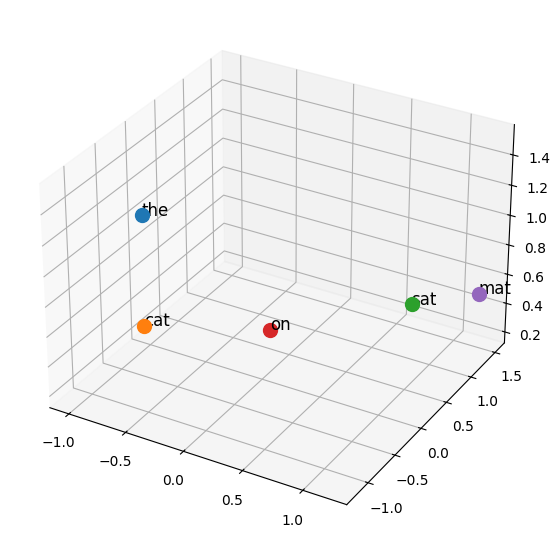

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')

for i, word in enumerate(vocab):
    x, y, z = C[i].detach().numpy()
    ax1.scatter(x, y, z, c=f'C{i}', s=100, label=word)
    ax1.text(x, y, z, word, size=12)

In [ ]:
# forward pass

# context embeddings
context = ["the", "cat"]
context_indices = [vocab[word] for word in context]
context_embeddings = C[context_indices].flatten()

# hidden layer
hidden_weights = torch.randn((embeddings_dim * 2, 4), requires_grad=True)
hidden_bias = torch.zeros(4, requires_grad=True)
hidden = torch.tanh(context_embeddings @ hidden_weights + hidden_bias)

print(f"hidden weights: {hidden_weights}\n")
print(f"hidden output: {hidden}\n")

# output layer
output_weights = torch.randn((4, len(vocab)), requires_grad=True)
output_bias = torch.zeros(len(vocab), requires_grad=True)
scores = hidden @ output_weights + output_bias

print(f"output weights: {output_weights}\n")
print(f"scores: {scores}\n")

probabilities = torch.softmax(scores, dim=0)
print(f"Probability distribution: {probabilities}")

hidden weights: tensor([[-0.5352,  1.0479,  1.5666,  1.1766],
        [-0.4695,  0.5522,  0.2828,  0.5265],
        [-0.3923, -0.8288,  0.5455,  0.3793],
        [ 1.0748,  0.0511, -0.4958, -0.1585],
        [-1.1306,  1.5274,  0.9896,  0.7776],
        [ 0.5082,  1.2520,  0.6349, -0.0573]], requires_grad=True)

hidden output: tensor([-0.5810, -0.9733,  0.4161, -0.4269], grad_fn=<TanhBackward0>)

output weights: tensor([[ 0.3062, -0.2890,  0.1879, -0.6503,  0.4491],
        [-1.8263,  0.0882, -0.0157, -0.7512, -0.3873],
        [-0.2409, -1.2876,  1.4123, -1.3063, -1.7207],
        [ 0.5714,  1.0349, -0.8485, -1.0028, -1.3223]], requires_grad=True)

scores: tensor([ 1.2554, -0.8954,  0.8559,  0.9936, -0.0354], grad_fn=<AddBackward0>)

Probability distribution: tensor([0.3531, 0.0411, 0.2368, 0.2718, 0.0971], grad_fn=<SoftmaxBackward0>)


In [ ]:
# loss
next_word = "sat"
loss = -torch.log(probabilities[vocab[next_word]])
print(f"loss: {loss.item()}")

loss.backward()

loss: 1.4403505325317383


In [ ]:
# optimization

learning_rate = 0.1

with torch.no_grad():
  C -= learning_rate * C.grad
  hidden_weights -= learning_rate * hidden_weights.grad
  hidden_bias -= learning_rate * hidden_bias.grad
  output_weights -= learning_rate * output_weights.grad
  output_bias -= learning_rate * output_bias.grad

  C.grad.zero_()
  hidden_weights.grad.zero_()
  hidden_bias.grad.zero_()
  output_weights.grad.zero_()
  output_bias.grad.zero_()

# Embeddings with real dataset

In [13]:
def create_embeddings_tensor(vocab_size, dim):
  embeddings = torch.randn(vocab_size, dim)
  embeddings[0] = torch.zeros(dim)

  return embeddings

In [14]:
embedding_dims = [50, 100, 200]
embeddings = {}

for test_dim in embedding_dims:
  embeddings[test_dim] = create_embeddings_tensor(vocab_size, test_dim)
  print(f"Created embeddings with dimension {test_dim}, shape: {embeddings[test_dim].shape}")

Created embeddings with dimension 50, shape: torch.Size([20002, 50])
Created embeddings with dimension 100, shape: torch.Size([20002, 100])
Created embeddings with dimension 200, shape: torch.Size([20002, 200])


# Model

In [75]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
    super(LanguageModel, self).__init__()

    # C
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.embeddings.weight.data.uniform_(-0.1, 0.1)

    # H
    self.hidden = nn.Linear(context_size * embedding_dim, hidden_dim)
    nn.init.xavier_uniform_(self.hidden.weight, gain=0.1)
    self.hidden.bias.data.zero_()

    # (U, W and b)
    self.output = nn.Linear(hidden_dim, vocab_size)
    nn.init.xavier_uniform_(self.output.weight, gain=0.1)
    self.output.bias.data.zero_()

    self.context_size = context_size
    self.embedding_dim = embedding_dim

  def forward(self, contexts):
    embeds = self.embeddings(contexts)          # (batch_size, context_size, embedding_dim)
    embeds = embeds.view(embeds.shape[0], -1)   # (batch_size, context_size * embedding_dim)

    hidden = torch.tanh(self.hidden(embeds))    # (batch_size, hidden_dim)

    scores = self.output(hidden)                # (batch_size, vocab_size)

    log_probs = torch.log_softmax(scores, dim=1)

    return log_probs

  def get_embeddings(self):
    return self.embeddings

In [76]:
class RedditDataset(Dataset):
  def __init__(self, tokenized_comments, word_to_idx, context_size):
    self.word_to_idx = word_to_idx
    self.context_size = context_size
    self.data = []

    for text in tokenized_comments:
      if len(text) <= context_size:
        continue

      for i in range(len(text) - context_size):
        context = text[i:i+context_size]
        target = text[i+context_size]

        context_indices = [self.word_to_idx.get(w, self.word_to_idx['<unk>'])
                            for w in context]
        target_index = self.word_to_idx.get(target, self.word_to_idx['<unk>'])

        self.data.append((context_indices, target_index))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    context, target = self.data[idx]
    return torch.tensor(context), torch.tensor(target)

In [77]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, device='cpu',
                scheduler=None, early_stopping_patience=3):

  model = model.to(device)

  history = {
    'train_loss': [],
    'val_loss': [],
    'train_perplexity': [],
    'val_perplexity': [],
    'best_val_loss': float('inf'),
    'best_epoch': 0
  }

  patience_counter = 0

  start_time = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    # training
    model.train()
    train_loss = 0.0
    train_examples = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for contexts, targets in train_pbar:
      contexts, targets = contexts.to(device), targets.to(device)

      optimizer.zero_grad()

      log_probs = model(contexts)

      loss = criterion(log_probs, targets)
      loss.backward()

      optimizer.step()

      batch_loss = loss.item() * contexts.size(0)
      train_loss += batch_loss
      train_examples += contexts.size(0)

      train_pbar.set_postfix({'loss': batch_loss / contexts.size(0)})

    avg_train_loss = train_loss / train_examples
    train_perplexity = np.exp(avg_train_loss)

    # validation
    model.eval()
    val_loss = 0.0
    val_examples = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

    with torch.no_grad():
      for contexts, targets in val_pbar:
        contexts, targets = contexts.to(device), targets.to(device)

        log_probs = model(contexts)

        loss = criterion(log_probs, targets)

        batch_loss = loss.item() * contexts.size(0)
        val_loss += batch_loss
        val_examples += contexts.size(0)

        val_pbar.set_postfix({'loss': batch_loss / contexts.size(0)})

      avg_val_loss = val_loss / val_examples
      val_perplexity = np.exp(avg_val_loss)

      if scheduler is not None:
        scheduler.step(avg_val_loss)

      history['train_loss'].append(avg_train_loss)
      history['val_loss'].append(avg_val_loss)
      history['train_perplexity'].append(train_perplexity)
      history['val_perplexity'].append(val_perplexity)

      if avg_val_loss < history['best_val_loss']:
            history['best_val_loss'] = avg_val_loss
            history['best_epoch'] = epoch
            # save the best model
            torch.save(model.state_dict(), 'best_bengio_model.pt')
            patience_counter = 0
      else:
          patience_counter += 1

      epoch_time = time.time() - epoch_start


      print(f"Epoch {epoch+1}/{epochs} - "
            f"Time: {epoch_time:.2f}s - "
            f"Train Loss: {avg_train_loss:.4f} - "
            f"Train PPL: {train_perplexity:.2f} - "
            f"Val Loss: {avg_val_loss:.4f} - "
            f"Val PPL: {val_perplexity:.2f}")

      if patience_counter >= early_stopping_patience:
            print(f"Early stopping after epoch {epoch+1}")
            break

  total_time = time.time() - start_time
  print(f"Total training time: {total_time:.2f} seconds")

  model.load_state_dict(torch.load('best_bengio_model.pt'))

  return model, history

In [78]:
def inference(model, context, word_to_idx, idx_to_word, temperature=1.0, max_length=20, device='cpu'):
  model.eval()
  model = model.to(device)

  if len(context) != model.context_size:
    raise ValueError(f"Context must have exactly {model.context_size} words")

  generated = list(context)

  with torch.no_grad():
    for _ in range(max_length):
      context_indices = [word_to_idx.get(w, word_to_idx['<unk>']) for w in context]
      context_tensor = torch.tensor([context_indices], dtype=torch.long).to(device)

      log_probs = model(context_tensor)
      probs = torch.exp(log_probs / temperature).squeeze()

      next_word_idx = torch.multinomial(probs, 1).item()
      next_word = idx_to_word[next_word_idx]

      generated.append(next_word)

      context = context[1:] + [next_word]

  return ' '.join(generated)

In [79]:
def visualize_embeddings_2d(model, word_to_idx, idx_to_word, num_words=100, filter_words=None):
    embeddings = model.get_embeddings().cpu().weight.detach().numpy()

    if filter_words and len(filter_words) > 0:
        # Create word_to_idx mapping (reverse of idx_to_word)
        word_to_idx = {word: idx for idx, word in idx_to_word.items()}

        # Find indices of filter words
        words_to_plot = []
        for word in filter_words:
            if word in word_to_idx:
                words_to_plot.append(word_to_idx[word])
            else:
                print(f"Warning: '{word}' not found in vocabulary")

        if not words_to_plot:
            print("None of the filter words were found in vocabulary. Using default behavior.")
            words_to_plot = list(range(2, 2 + num_words))  # Default: Skip <pad> and <unk>
    else:
        # Default behavior: top N frequent words
        words_to_plot = list(range(2, 2 + num_words))  # Skip <pad> and <unk>


    # apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings[words_to_plot])

    # Plot
    plt.figure(figsize=(15, 12))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

    # add word labels
    for i, idx in enumerate(words_to_plot):
        plt.annotate(idx_to_word[idx],
                   xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                   xytext=(5, 2),
                   textcoords='offset points',
                   fontsize=9)

    plt.title(f'PCA visualization of {num_words} word embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('word_embeddings_2d.png')
    plt.tight_layout()
    plt.show()

# Tests

In [80]:
# set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'
print(f"Using device: {device}\n")

# define hyperparameters
context_size = 4
embedding_dim = 100
hidden_dim = 128
batch_size = 64
learning_rate = 0.0005
weight_decay = 0.0001
epochs = 25

# loading dataset
dataset = RedditDataset(tokenized_comments, word_to_idx, context_size)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}\n")
print(f"Validation samples: {len(val_dataset)}\n")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# creating model
model = LanguageModel(vocab_size, embedding_dim, context_size, hidden_dim)
print(model)

Using device: cuda

Training samples: 5454810

Validation samples: 606090

LanguageModel(
  (embeddings): Embedding(20002, 100)
  (hidden): Linear(in_features=400, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=20002, bias=True)
)


In [81]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
# train model
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    epochs=epochs, device=device, scheduler=scheduler
)

In [83]:
print(f'model training history: {history}\n')

model training history: {'train_loss': [6.049589132073821, 5.851193979304885, 5.821598226534405, 5.808559436826559, 5.801225941748875, 5.796433659893399, 5.79296351372604, 5.789807663279333, 5.7873165101425315, 5.78528409452419, 5.783556710198921, 5.782122541450854, 5.781470991155613, 5.780393486251315, 5.779878383786767, 5.77916124839856], 'val_loss': [5.877145092976178, 5.830535290199505, 5.810856502166148, 5.803899745530168, 5.798315400623634, 5.79262112100272, 5.792071757094492, 5.788289878685789, 5.787047210451924, 5.783823214224131, 5.781086841293038, 5.78137616267188, 5.778805491878222, 5.779239086342522, 5.78006589273475, 5.7792770627146455], 'train_perplexity': [423.9388113965226, 347.6492187478424, 337.51104190548824, 333.1388722489175, 330.7047362403205, 329.123697351146, 327.9835693636889, 326.95013381152364, 326.13666461895514, 325.47449250048453, 324.91275826899533, 324.4471125323326, 324.23578777220297, 323.88661027474575, 323.7198184446884, 323.48775072894915], 'val_per

In [58]:
# load model from file
# model.load_state_dict(torch.load('best_bengio_model.pt', weights_only=True))
# model.eval()
# model

In [128]:
inference(model, ['uma', 'dica', 'de', 'investimentos'], word_to_idx, idx_to_word, device=device, max_length=12)

'uma dica de investimentos lá e gastos muito dos estados humano central do banco em capitalismo'

In [114]:
untrained_model = LanguageModel(vocab_size, embedding_dim, context_size, hidden_dim)

inference(untrained_model, ['o', 'brasil', 'é', 'um'], word_to_idx, idx_to_word, device=device, max_length=10)

'o brasil é um constitucional cursos interpretar residencial num respeita sqn normativa internacional sei'

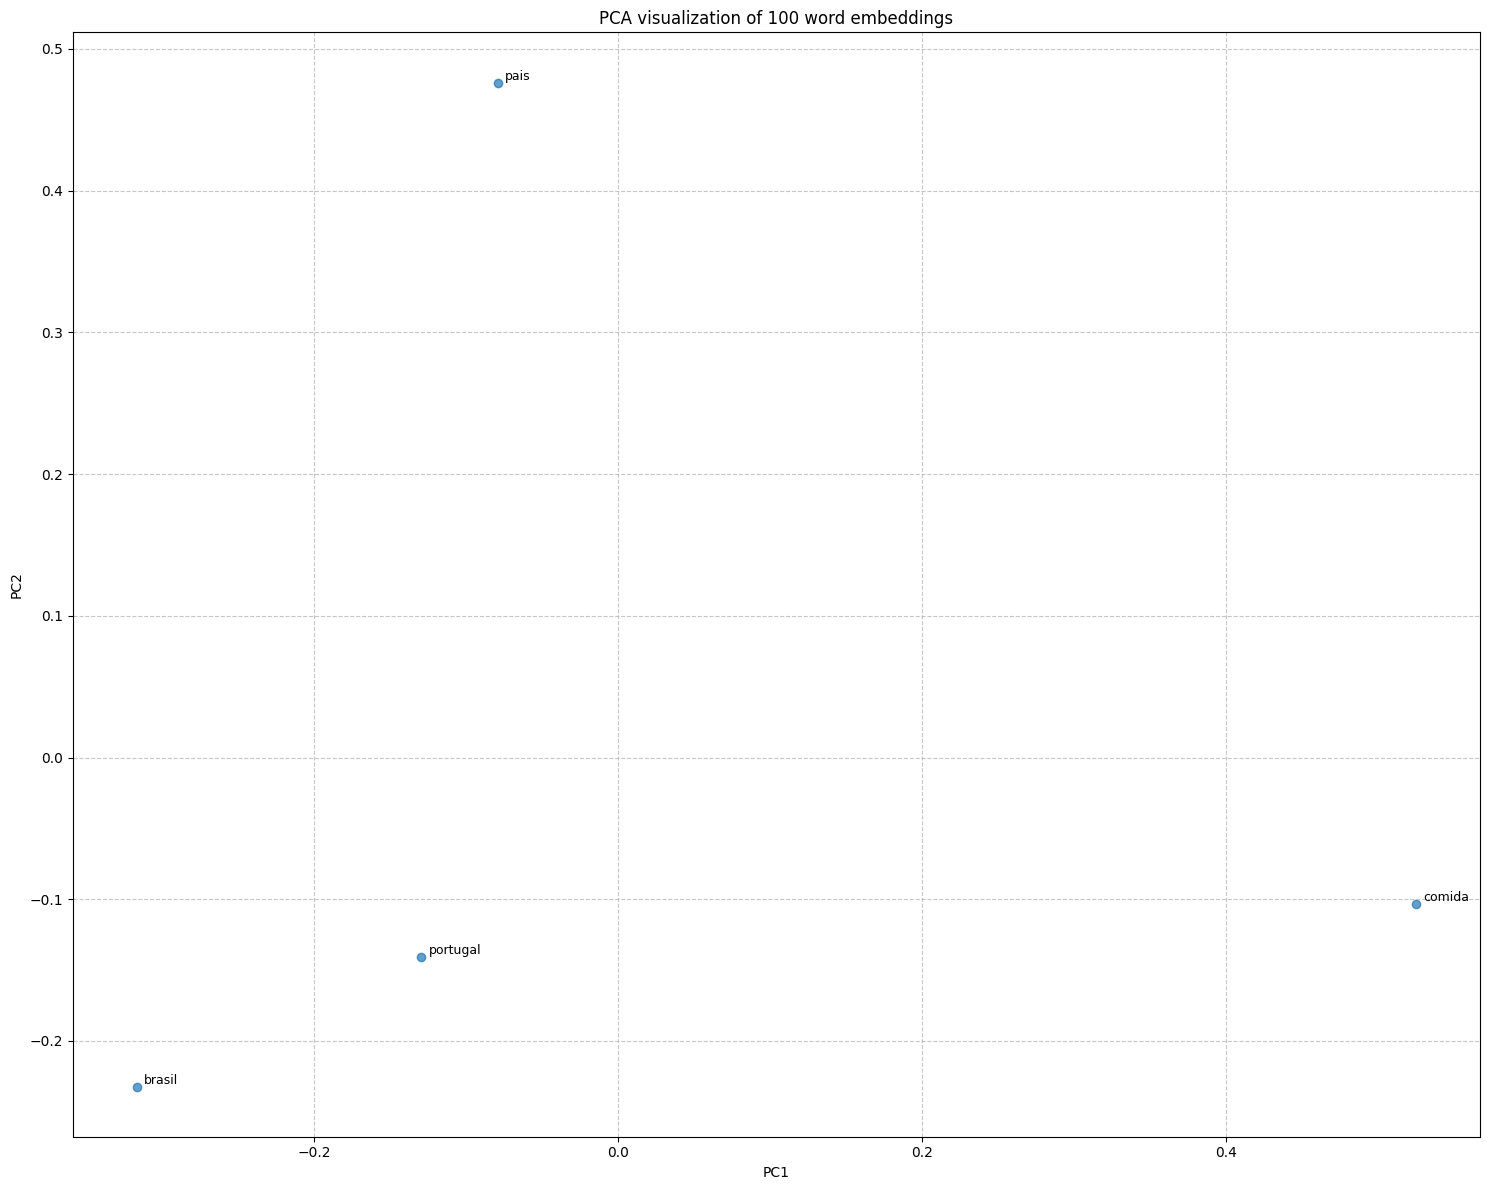

In [135]:
visualize_embeddings_2d(untrained_model, word_to_idx, idx_to_word, filter_words=['brasil', 'pais', 'comida', 'portugal'])

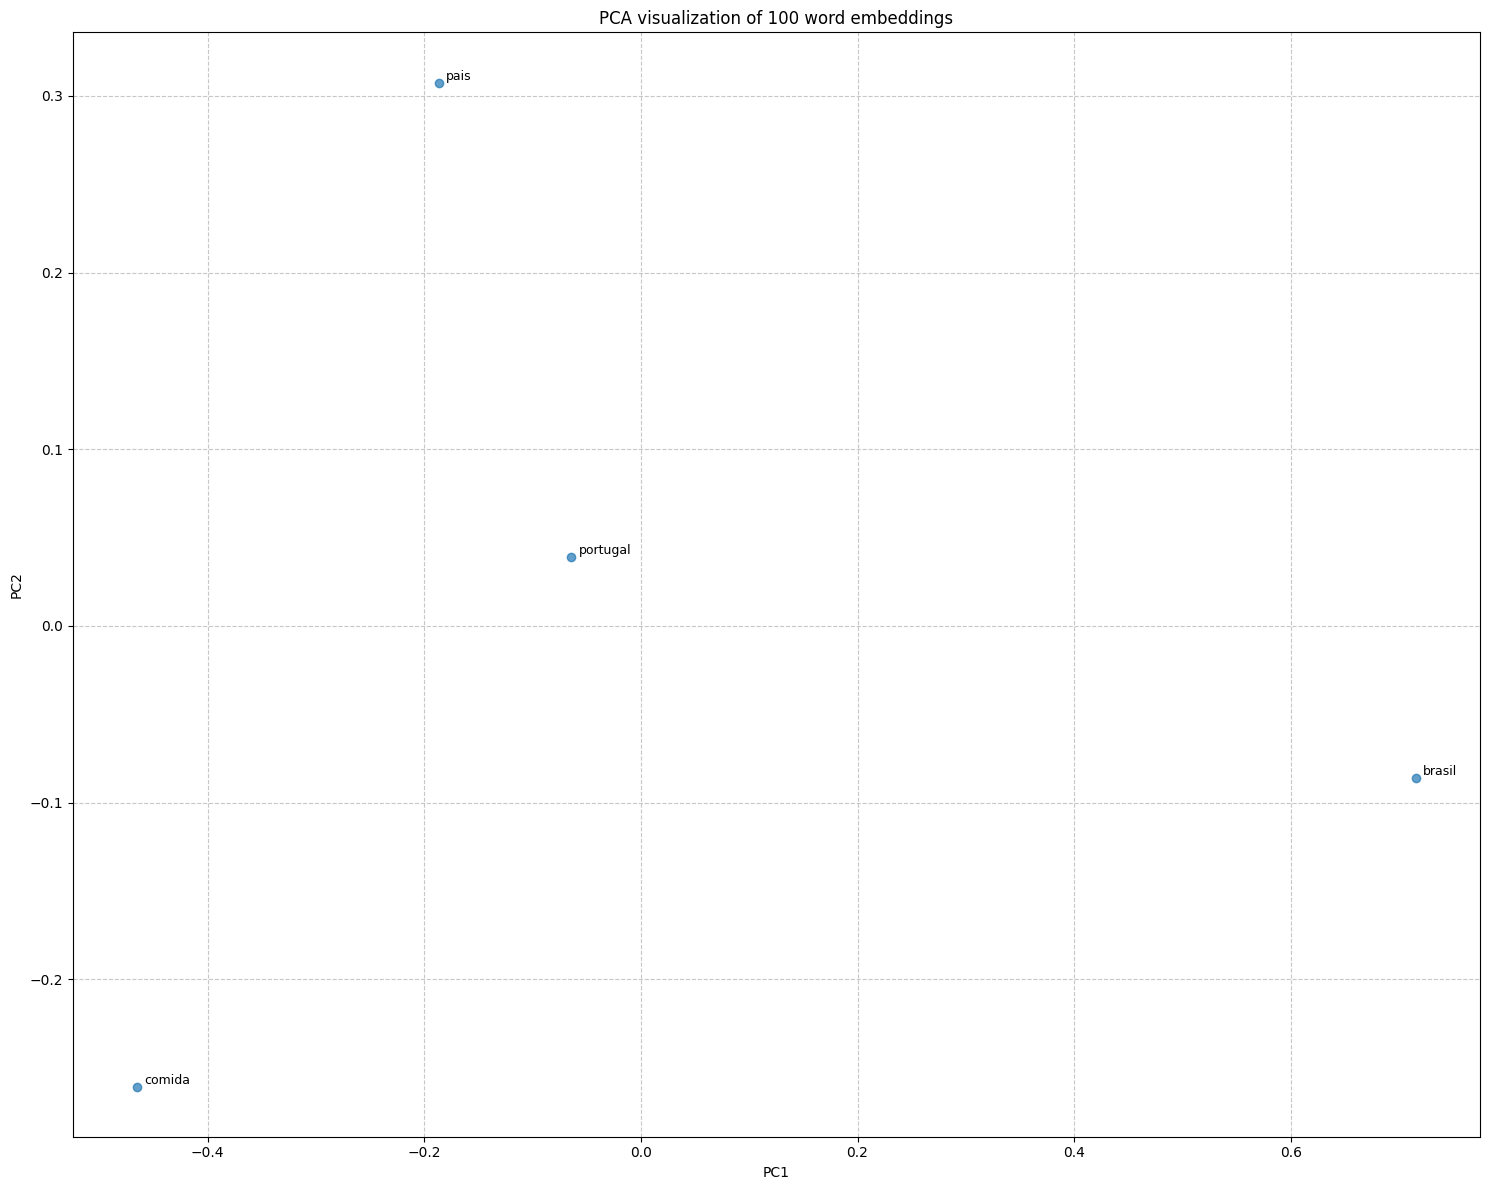

In [136]:
visualize_embeddings_2d(model, word_to_idx, idx_to_word, filter_words=['brasil', 'pais', 'comida', 'portugal'])